## ML for Asset Management - Marcos Lopez Prado 

**Date:** 2025-05-28

### Section 5 - Financial Labels

Supervised learning algorithms solve tasks with the help of examples (a y array). 

There are two main types: Classification & Regression

Researchers need to ponder very carefully how they define labels, because labels determine the task that the algorithm is going to learn.

In this section, we discuss four important labeling strategies.

### 5.2 Fixed Horizon Method

Virtually all academic studies in financial ML use the fixed-horizon labeling method.

Consider a features matrix X with I rows:
 $$\{X_i\}_{i=1,..I}$$

this is sampled from a series of time bars (1-minute, 5-minute, daily, etc.) with index $t = 1, ..., T$, where I $\leq$ T.

We compute the price return of a horizon h as:

$$r_{t_{i,0},t_{i,1}} = \frac{p_{t_{i,1}}}{p_{t_{i,0}}}-1$$

Where $t_{i,0}$ is the bar index associated with the ith observed features and $t_{i,1} = t_{i,0} +h$ is the bar index after the fixed horizon of h bars has elapsed. 

This method assigns a label $y_i = \{-1, 0, 1\}$ to an observation $X_i$, with:

$y_i = -1$ if $r_{t_{i,0},t_{i,1}} < -\tau$

$y_i = 0$ if $|r_{t_{i,0},t_{i,1}}| \leq \tau$

$y_i = 1$ if $r_{t_{i,0},t_{i,1}} > \tau$

where $\tau$ is a predefined constant threshold

When the bars are sampled at a regular chronological time frequency, they are known as time bars. Time bars are also very popular in the financial literature. The combination of time bars with fixed-horizon labeling results in fixed time horizons. 

Despite popularity, there are several reasons to avoid this. 

First, returns computed on time bars exhibit substantial heteroscedasticity (defn: the variance of the error terms (residuals) in a regression model is not constant), as a consequence of intraday seasonal activity patterns. Imagine a scatterplot where the cloud of data points gets wider as x increases — that’s heteroscedasticity. 

Applying a constant threshold in conjunction with these returns will transfer that seasonality to the labels, thus the distribution of labels will not be stationary. For instance, obtaining a 0 label at the open or the close is more informative (in the sense of unexpected) than obtaining a 0 label around noon, or during the night.

One solution is to apply the fixed-horizon method on tick, volume or dollar bars.

Another solution is to label based on standardized returns $z_{t_{i,0},t_{i,1}}$ adjusted for the volatility predicted over the interval of bars $[t_{i,0},t_{i,1}]$

A second concern of the fixed horizon method is that it dismisses all information regarding the intermediate returns within the interval $[t_{i,0},t_{i,1}]$

This is problematic, because positions are typically managed according to profit taking and stop-loss levels. In the particular case of stop losses, those levels may be self-imposed by the portfolio manager, or enforced by the risk department. Accordingly, fixed-horizon labels may not be representative of the outcome of a real investment.

A third concern of the fixed-horizon method is that investors are rarely interested in forecasting whether a return will exceed a threshold $\tau$ at a precise point in time. It would be more practical to predict the side of the next absolute return that exceeds a threshold $\tau$ within a maximum horizon h. The following method deals with these three concerns.




### Triple-Barrier Method

In financial applications, a more realistic method is to make labels reflect the success or failure of a position.

A typical trading rule adopted by portfolio managers is to hold a position until the first of three possible outcomes occurs: 

- (1) the unrealized profit target is achieved, and the position is closed with success; 

- (2) the unrealized loss limit is reached, and the position is closed with failure; 

- (3) the position is held beyond a maximum number of bars, and the position is closed without neither failure nor success.

In a time plot of position performance, the first two conditions define two horizontal barriers, and the third condition defines a vertical barrier. 

The index of the bar associated with the first touched barrier is recorded as $t_{i,1}$

When the profit-taking barrier is touched first, we label the observation as $y_i = 1$. When the stop-loss barrier is touched first, we label the observation as $y_i = -1$. When the vertical barrier is touched first, we have two options: we can either label it $y_i = 0$, or we can label it $y_i$ = $sgn[r_{t_{i,0},t_{i,1}}]$

Setting profit taking and stop-loss barriers requires knowledge of the position side associated with the ith observation.

When the position side is unknown, we can still set horizontal barriers as a function of the volatility predicted over the interval of bars $[t_{i,0},t_{i,0}+h]$ where h is the number of bars until the vertical barrier is touched. 

A key advantage of the triple-barrier method over the fixed-horizon method is that it incorporates information about the path spanning the interval of bars $[t_{i,0},t_{i,0}+h]$.

One disadvantage is that touching a barrier is a discrete event, which may or may not occur by a thin margin. This caveat is addressed by the following method.


### 5.4 Trend-Scanning Method.

In this section we introduce a new labeling method that does not require defining h or profit-taking or stop-loss barriers. The general idea is to identify trends and let them run for as long and as far as they may persist, without setting any barriers.

We first need to define what constitutes a trend. Consider a series of observations $\{x_t\}_{t=1,...,T}$ where $x_t$ may represent the price of a security we aim to predict. We wish to assign a label $y_t \in \{-1, 0, 1\}$ to every observation in $x_t$ based on whether it is part of a downtrend, no trend, or an uptrend. 

One possibility is to compute the t-value $(t_{\hat{\beta}_1})$ associated with the estimated regressor coefficient in a linear time-trend model. 

To determine the trend, we fit a linear regression model on a rolling window:


$$x_{t+l} = \beta_0 + \beta_1 l + \varepsilon_{t+l}$$


Where:
- $(l = 0, 1, ..., L-1)$ indexes the window length L,
- $(\beta_1)$ is the slope (trend strength),
- $(\varepsilon_{t+l})$ is the error term.

and

$$t_{\hat{\beta}_1} = \frac{\hat{\beta}_1}{\hat{\sigma}_{\hat{\beta}_1}}$$

where $(\hat{\sigma}_{\hat{\beta}_1})$ is the estimated standard error of $(\hat{\beta}_1)$.

The following code computes the t-value on the sample determined by L.

In [2]:
import statsmodels.api as sm
import numpy as np

#---------------------------------------------------
def tValLinR(close):
    # Compute t-value of the slope from a linear trend regression
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sm.OLS(close, x).fit()
    return ols.tvalues[1]


### 5.4 Cont.

Different values of L lead to different t-values. To solve this issue we can try a set of alternatives for L and then pick the L that maximizes $|t_{\hat{\beta}_1}|$. In this way, we label xt according to the most statistically significant trend observed in the future, out of multiple possible look-forward periods.

This is implemented in the following code:

The arguments are: 

- molecule, which is the index of observations we wish to label; 

- close, which is the time series of {$x_t$}; 

- span, which is the set of values of L that the algorithm will evaluate, in search for the maximum absolute t-value.

The output is a data frame where the index is the timestamp of the $x_t$.

Column **t1** reports the timestamp of the farthest observation used to find the most significant trend.

Column **tVal** reports the $t$-value associated with the most significant linear trend among the set of evaluated look-forward periods.

Column **bin** is the label ($y_t$).



In [4]:
# Implementation of the Trend-Scanning Method

import pandas as pd

def getBinsFromTrend(molecule, close, span):
    '''
    Derive labels from the sign of t-value of linear trend.
    Output includes:
    - t1: End time for the identified trend
    - tVal: t-value associated with the estimated trend coefficient
    - bin: Sign of the trend
    '''
    out = pd.DataFrame(index=molecule, columns=['t1', 'tVal', 'bin'])
    hrzns = range(*span)

    for dt0 in molecule:
        df0 = pd.Series()
        iloc0 = close.index.get_loc(dt0)
        if iloc0 + max(hrzns) > close.shape[0]:
            continue

        for hrzn in hrzns:
            dt1 = close.index[iloc0 + hrzn - 1]
            df1 = close.loc[dt0:dt1]
            df0.loc[dt1] = tValLinR(df1.values)

        dt1 = df0.replace([np.inf, -np.inf, np.nan], 0).abs().idxmax()
        out.loc[dt0, ['t1', 'tVal', 'bin']] = df0.index[-1], df0[dt1], np.sign(df0[dt1])

    # Prevent leakage and cast types
    out['t1'] = pd.to_datetime(out['t1'])
    out['bin'] = pd.to_numeric(out['bin'], downcast='signed')
    
    return out.dropna(subset=['bin'])


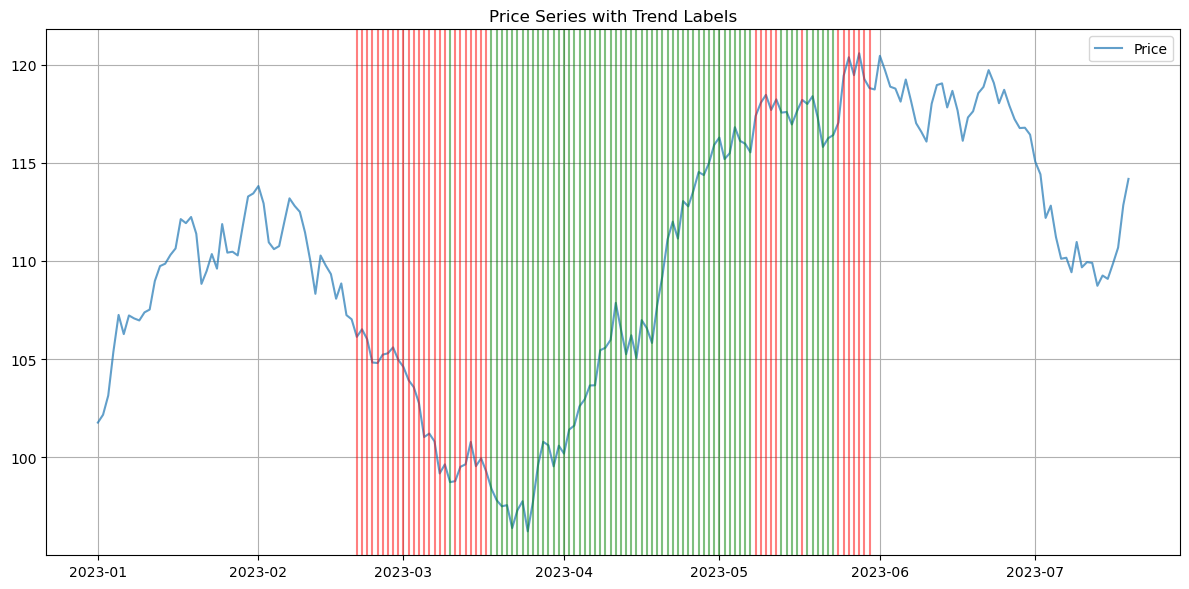

In [7]:
# Implementation of the Trend-Scanning Method:
import matplotlib.pyplot as plt 

# Generate a sample price series
np.random.seed(0)
dates = pd.date_range(start='2023-01-01', periods=200)
prices = np.cumsum(np.random.randn(200)) + 100
close = pd.Series(prices, index=dates)

# Apply getBinsFromTrend to a subset
molecule = dates[50:150]
trend_labels = getBinsFromTrend(molecule, close, span=(5, 20))

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(close, label='Price', alpha=0.7)
colors = {1: 'green', 0: 'gray', -1: 'red'}
for idx, row in trend_labels.iterrows():
    plt.axvline(x=idx, color=colors[row['bin']], alpha=0.5)
plt.title("Price Series with Trend Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.5 - Meta Labeling / Bet Sizing

A common occurrence in finance is that we know whether we want to buy or sell a particular security, however we are less certain about how much we should bet.

A model that determines a position’s side may not be the best one to determine that position’s size. Perhaps the size should be a function of the recent performance of the model, whereas that recent performance is irrelevant to forecast the position’s side.

Consider an investment strategy with a precision of 60% and a recall of 90%. A 90% recall means that the strategy predicts ninety out of one hundred true investment opportunities. A 60% precision means that out of one hundred predicted opportunities, sixty are true. 

Meta-labeling is useful for avoiding or at least reducing an investor’s exposure to false positives. It achieves that by giving up some recall in exchange for higher precision. In the example above, adding a meta-labeling layer may result in a recall of 70% and a precision of 70%, hence improving the model’s F1- score (the harmonic average of precision and recall).

The goal of meta-labeling is to train a secondary model on the prediction outcomes of a primary model, where losses are labeled as “0” and gains are labeled as “1.” Therefore, the secondary model does not predict the side. Instead, the secondary model predicts whether the primary model will succeed or fail at a particular prediction (a meta-prediction). The probability associated with a “1” prediction can then be used to size the position, as explained next.

### 5.5.1 Bet Sizing by Expected Sharpe Ratio

Let p be the expected probability that the opportunity yields a profit $\pi$, and 1-p the expected probabilty that the opportunity yields a profit $-\pi$ (loss), for some symmetric payoff $\pi > 0$.

The expected profit from the opportunity is $$\mu = p \pi +(1-p)(-\pi) = \pi(2p-1)$$

The expected variance from the opportunity is $$\sigma^2 = 4\pi^2p(1-p)$$

The sharpe ratio associated with the opportunity can therefore be estimated as: $$z = \frac{\mu}{\sigma}=\frac{p-0.5}{\sqrt{p(1-p)}}$$

Assuming the Sharpe ratio of opportunities follows a standard Gaussian distribution, we may derive the bet size as: $$ m = 2Z[z]-1$$ Where Z[.] is the cdf of N(0,1) and $m \in [-1,1]$ follows a uniform distribution.

### 5.5.2 Ensemble Bet Sizing

Consider \( n \) meta-labeling classifiers that make a binary prediction on whether an opportunity will be profitable or not,  
\( y_i \in \{0, 1\}, \quad i = 1, \ldots, n \).  

The true probability of being profitable is \( p \), and predictions \( y_i \) are drawn from a Bernoulli distribution, so:

$$
\sum_{i=1}^{n} y_i \sim \mathcal{B}[n, p]
$$

where \( \mathcal{B}[n, p] \) is a binomial distribution of \( n \) trials with probability \( p \).  

Assuming that the predictions are independent and identically distributed, the **de Moivre–Laplace theorem** states that the distribution of \( \sum_{i=1}^{n} y_i \) converges to a Gaussian distribution with mean \( np \) and variance \( np(1 - p) \) as \( n \to \infty \).  

Accordingly,

$$
\lim_{n \to \infty} \frac{1}{n} \sum_{i=1}^{n} y_i \sim \mathcal{N} \left( p, \frac{p(1 - p)}{n} \right)
$$

which is a special case of the **Lindeberg–Lévy central limit theorem**.

---

Let us denote as $\hat{p} $ the average prediction across the n meta-labeling classifiers:

$$
\hat{p} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$

The standard deviation associated with $\hat{p} $ is:

$$
\sqrt{ \frac{ \hat{p}(1 - \hat{p}) }{n} }
$$

Under the null hypothesis $ H_0 : p = \frac{1}{2} $, the test statistic becomes:

$$
t = \frac{ \hat{p} - \frac{1}{2} }{ \sqrt{ \hat{p}(1 - \hat{p}) / n } } = \frac{ \hat{p} - \frac{1}{2} }{ \sqrt{ \hat{p}(1 - \hat{p}) } \cdot \sqrt{1/n} } = \frac{ \hat{p} - \frac{1}{2} }{ \sqrt{ \hat{p}(1 - \hat{p}) } / \sqrt{n} }
$$

with $ t \in (-\infty, \infty) $, which follows a **t-distribution** with $ n - 1 $ degrees of freedom.

---

We derive the **bet size** m as:

$$
m = 2t_{n-1}[t] - 1
$$

where $ t_{n-1}[\cdot] $ is the **cumulative distribution function (CDF)** of the Student’s t-distribution with $ n - 1 $ degrees of freedom.

Hence:

$$
m \in [-1, 1]
$$

and $m$ follows a **uniform distribution**.


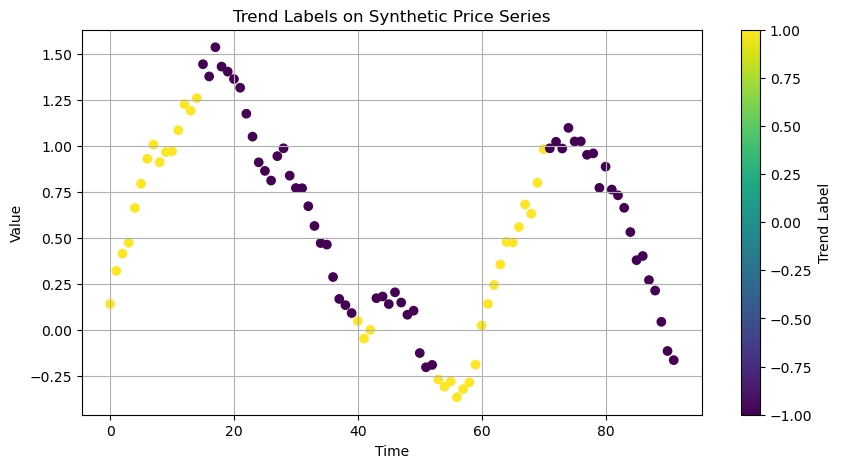

In [23]:
# Testing the Trend-Scanning Labeling Algorithm:

# Generates a Gaussian random walk with a sine trend to force some inflection points.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate time series with trend + noise
df0 = pd.Series(np.random.normal(0, 0.1, 100)).cumsum()
df0 += np.sin(np.linspace(0, 10, df0.shape[0]))

# Generate trend-based labels
df1 = getBinsFromTrend(df0.index, df0, span=[3, 10, 1])

# Plot labeled points with color-coded trend direction
plt.figure(figsize=(10, 5))
scatter = plt.scatter(
    df1.index, 
    df0.loc[df1.index].values, 
    c=df1['bin'].values, 
    cmap='viridis'
)

plt.title("Trend Labels on Synthetic Price Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.colorbar(scatter, label='Trend Label')
plt.grid(True)

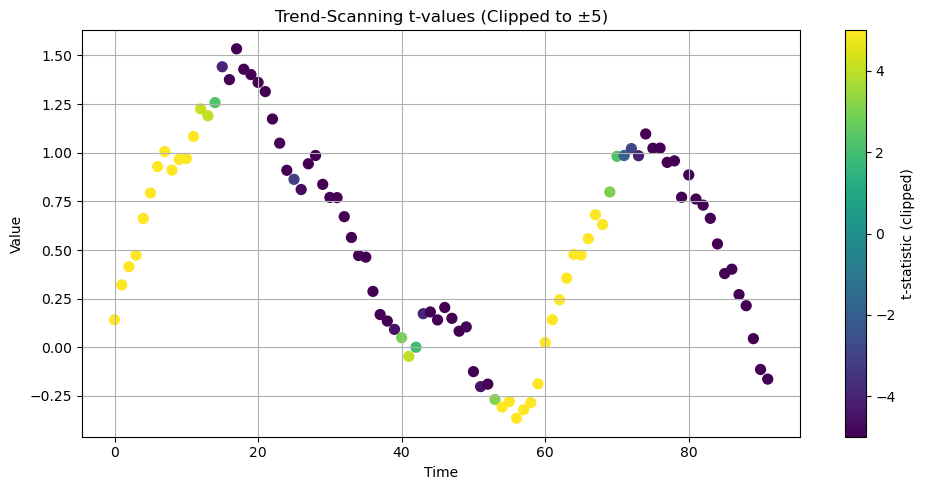

In [26]:
# Plot with custom t-value coloring

# Clip t-values to the range [-5, 5]
df1['tVal_clipped'] = df1['tVal'].clip(-5, 5)

cmap = plt.get_cmap('viridis')

plt.figure(figsize=(10, 5))
scatter = plt.scatter(
    df1.index,
    df0.loc[df1.index].values,
    c=df1['tVal_clipped'].values,
    cmap='viridis',
    s=50
)
plt.title("Trend-Scanning t-values (Clipped to ±5)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.colorbar(scatter, label="t-statistic (clipped)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Conclusions:

We presented four alternative labeling methods that can be useful in financial applications.

- The fixed-horizon method, although implemented in most financial studies, suffers from multiple limitations. 

- Among these limitations, we listed that the distribution of fixed-horizon labels may not be stationary, that these labels dismiss path information, and that it would be more practical to predict the side of the next absolute return that exceeds a given threshold.

- The triple-barrier method answers these concerns by simulating the outcome of a trading rule. One disadvantage is that touching a barrier is a discrete event, which may or may not occur by a thin margin. 

- To address that, the trend- scanning method determines the side of the strongest linear trend among alternative look-forward periods, with its associated p-value. Trend-scanning labels are often intuitive, and can be used in classification as well as regression problems. 

- Finally, the meta-labeling method is useful in applications where the side of a position is predetermined, and we are only interested in learning the size. A proper sizing method can help improve a strategy’s performance, by giving up some of the recall in exchange for higher precision.



## Exercises:

### Ex 1: Fixed-Horizon Labeling Using SPY 1-Minute Bars

**Objective:**  
Given a time series of SPY (used as a proxy for E-mini S&P 500 futures), compute trend labels on one-minute bars using the fixed-horizon method, where the threshold $\tau $ is set at two standard deviations of one-minute returns.

**Tasks**:
- (a) Compute the overall distribution of labels (uptrend, downtrend, no-trend).  
- (b) Compute the distribution of labels across all days, for each hour of the trading session.  
- (c) Analyze how the distributions in (b) differ from (a), and explain why.


In [116]:
import yfinance as yf
import pandas as pd

# (a) Compute the overall distribution of labels (uptrend, downtrend, no-trend):

# Download SPY 1-minute data
spy = yf.download("SPY", interval="1m", period="7d", progress=False, auto_adjust=False)

# Keep only the Close column and rename it to 'price'
spy['price'] = spy['Close']
spy = spy[['price']].copy()

# Compute forward returns of 5 minutes
h = 5
spy['fwd_price'] = spy['price'].shift(-h)
spy = spy.dropna()
spy['fwd_ret'] = spy['fwd_price'] / spy['price'] - 1

# Labeling threshold
tau = 2 * spy['price'].pct_change().dropna().std()

# Assign fixed-horizon labels
spy['label'] = 0
spy.loc[spy['fwd_ret'] > tau, 'label'] = 1
spy.loc[spy['fwd_ret'] < -tau, 'label'] = -1

# Display the first few labeled rows
spy[['price', 'fwd_price', 'fwd_ret', 'label']].head()



Price,price,fwd_price,fwd_ret,label
Ticker,,,,
Datetime,,,,
2025-05-19 13:30:00+00:00,589.000000,589.190002,0.000323,0
2025-05-19 13:31:00+00:00,588.780029,589.590027,0.001376,1
2025-05-19 13:32:00+00:00,588.989990,589.520020,0.000900,0
2025-05-19 13:33:00+00:00,589.080017,589.780029,0.001188,1
2025-05-19 13:34:00+00:00,589.210022,589.929993,0.001222,1


label        -1         0         1
hour                               
13     0.104762  0.652381  0.242857
14     0.091787  0.797101  0.111111
15     0.030952  0.907143  0.061905
16     0.033413  0.940334  0.026253
17     0.071429  0.871429  0.057143
18     0.102871  0.858852  0.038278
19     0.157385  0.736077  0.106538


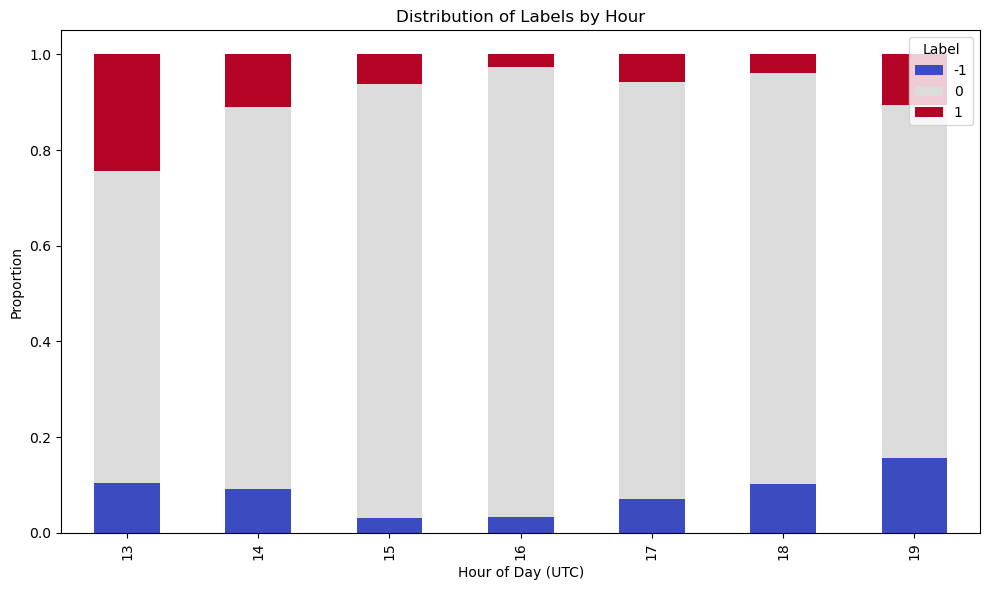

In [128]:
# (b) Compute the distribution of labels across all days, for each hour of the trading session. 

# Add hour and date columns
spy['hour'] = spy.index.hour
spy['date'] = spy.index.date

# Compute label distribution by date and hour
label_distribution_by_hour = spy.groupby(['hour'])['label'].value_counts(normalize=True).unstack().fillna(0)

# Display the result
print(label_distribution_by_hour)

# Plotting
ax = label_distribution_by_hour.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')

plt.title("Distribution of Labels by Hour")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Proportion")
plt.legend(title="Label", loc="upper right")
plt.tight_layout()
plt.show()


### Exercise 2: 

Repeat Ex 1, but now with standardized returns with a lookback of an hour:

z_label        -1         0         1
hour                                 
13       0.019048  0.971429  0.009524
14       0.012077  0.971014  0.016908
15       0.002381  0.978571  0.019048
16       0.026253  0.957041  0.016706
17       0.054762  0.909524  0.035714
18       0.062201  0.923445  0.014354
19       0.082324  0.849879  0.067797


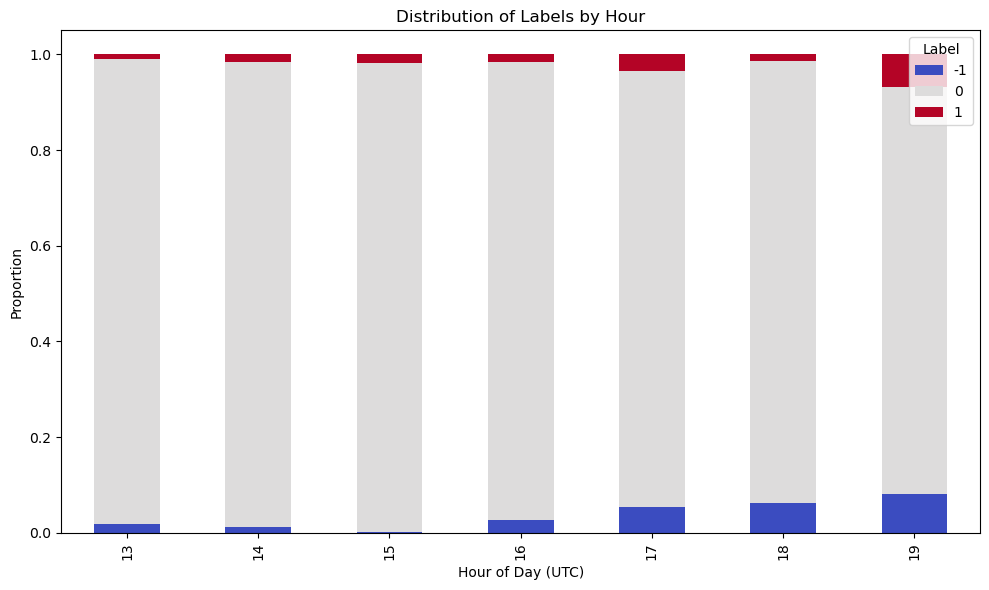

In [123]:
# Rolling mean and std from past 60 mins (1 hour of 1-min data)
spy['hourly_mean_ret'] = spy['fwd_ret'].rolling(window=60).mean()
spy['hourly_std_ret'] = spy['fwd_ret'].rolling(window=60).std()

# Z-score (standardized forward return)
spy['fwd_ret_zscore'] = (spy['fwd_ret'] - spy['hourly_mean_ret']) / spy['hourly_std_ret']

# Assign labels based on z-score:
# Labeling threshold
tau_std = 2  # Standard deviations

# Assign fixed-horizon labels
spy['z_label'] = 0
spy.loc[spy['fwd_ret_zscore'] > tau_std, 'z_label'] = 1
spy.loc[spy['fwd_ret_zscore'] < -tau_std, 'z_label'] = -1

# Compute label distribution by date and hour
z_labels_hourly = spy.groupby(['hour'])['z_label'].value_counts(normalize=True).unstack().fillna(0)

# Display the result
print(z_labels_hourly)

# Plotting
ax = z_labels_hourly.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')

plt.title("Distribution of Labels by Hour")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Proportion")
plt.legend(title="Label", loc="upper right")
plt.tight_layout()
plt.show()

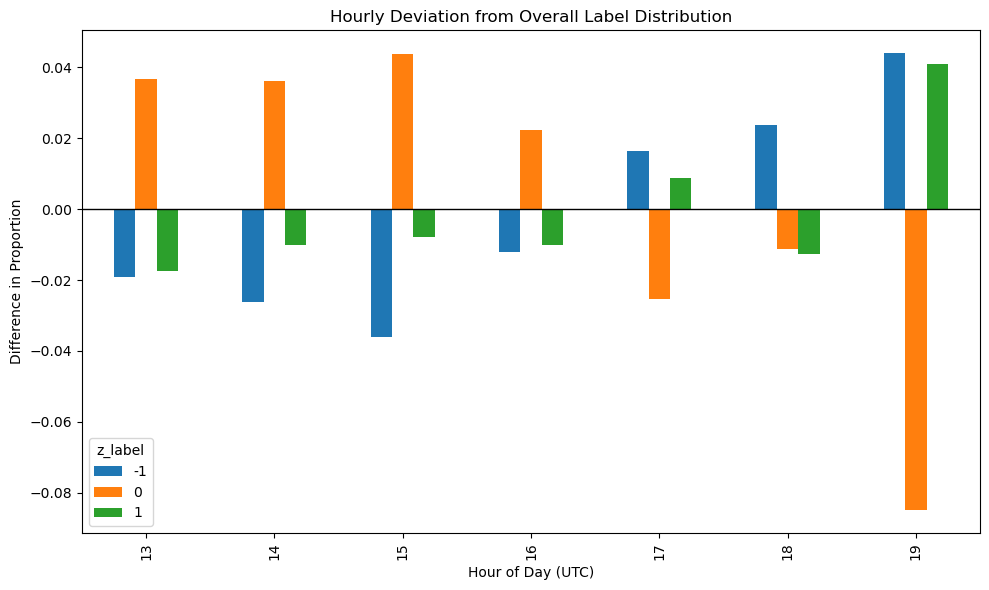

In [126]:
overall_dist = spy['z_label'].value_counts(normalize=True).sort_index()

# Repeat as a dataframe to align with hours
overall_dist_df = pd.DataFrame([overall_dist] * len(z_labels_hourly), index=z_labels_hourly.index)

# Compute difference
diff = z_labels_hourly - overall_dist_df

# Plot deviations
diff.plot(kind='bar', figsize=(10, 6), title="Hourly Deviation from Overall Label Distribution")
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("Difference in Proportion")
plt.xlabel("Hour of Day (UTC)")
plt.tight_layout()
plt.show()


### Exercise 3: Triple Barrier Method (Volume Bars)

Repeat Exercise 1, where this time you apply the triple-barrier method on volume bars. The maximum holding period is the average number of bars per day, and the horizontal barriers are set at two standard deviations of bar returns. How do results compare to the solutions from Exercises 1 and 2?

100%|██████████| 478/478 [00:00<00:00, 452670.42it/s]

label      -1.0       1.0
hour                     
13     0.148148  0.851852
14     0.303797  0.696203
15     0.301887  0.698113
16     0.460000  0.540000
17     0.651515  0.348485
18     0.683333  0.316667
19     0.620690  0.379310


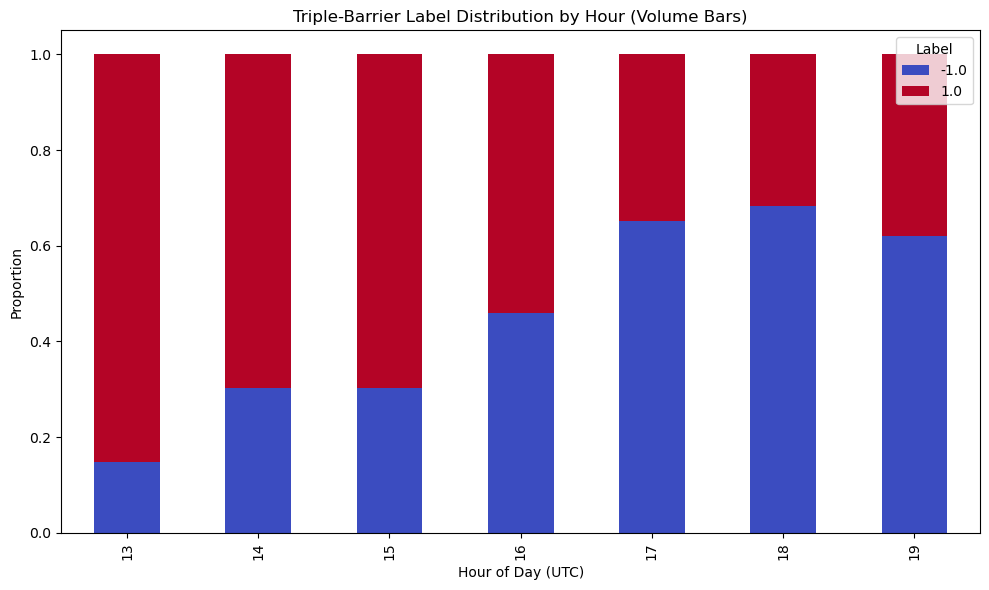

In [151]:
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm

# Download SPY 1-minute data
data = yf.download("SPY", interval="1m", period="7d", progress=False, auto_adjust=False)

# Extract Close and Volume as Series (not DataFrames)
spy = pd.DataFrame()
spy['Close'] = data['Close'].squeeze()
spy['Volume'] = data['Volume'].squeeze()

# Ensure index is datetime and drop any NaNs
spy.index = pd.to_datetime(spy.index)
spy = spy.dropna()

# Step 2: Compute 1-minute returns
spy['return'] = spy['Close'].pct_change()
spy.dropna(inplace=True)  # Drop first row with NaN return

# Target volume per bar: average daily volume divided by number of days
n_days = spy.index.normalize().nunique()
bars_per_day_desired = 100  # Aim for 100 volume bars per day
target_vol = spy['Volume'].sum() / (n_days * bars_per_day_desired)

bars = []
cum_vol = 0.0
bar = []

for i, row in spy.iterrows():
    cum_vol += row['Volume']  # ✅ row['Volume'] is float
    bar.append((i, row['Close']))  # ✅ row['Close'] is float

    if cum_vol >= target_vol:
        # Emit a volume bar with the timestamp and last close in the chunk
        timestamp = bar[-1][0]
        close_price = bar[-1][1]
        bars.append({'timestamp': timestamp, 'Close': close_price})
        cum_vol = 0.0
        bar = []

# Build DataFrame of volume bars
volume_bars = pd.DataFrame(bars).set_index('timestamp')

# Add returns for triple-barrier method
volume_bars['return'] = volume_bars['Close'].pct_change()
volume_bars.dropna(inplace=True)

# Step 4: Compute maximum holding period (the avg number of bars per day)

# Add a date column to volume bars
volume_bars['date'] = volume_bars.index.date

# Count number of bars per day
bars_per_day = volume_bars.groupby('date').size()

# Compute average
avg_holding_period = int(bars_per_day.mean())

# Step 5: Apply triple-barrier method:

barrier_width = 2 * volume_bars['return'].std()

def apply_triple_barrier(prices, max_horizon, upper, lower):
    labels = []
    prices = prices.values

    for i in tqdm(range(len(prices) - max_horizon)):
        entry_price = prices[i]
        label = 0  # Default

        for j in range(1, max_horizon):
            future_price = prices[i + j]
            ret = (future_price / entry_price) - 1

            if ret > upper:
                label = 1
                break
            elif ret < -lower:
                label = -1
                break

        labels.append(label)

    return pd.Series(labels, index=volume_bars.index[:len(labels)])

volume_bars['label'] = apply_triple_barrier(
    prices=volume_bars['Close'],
    max_horizon=avg_holding_period,
    upper=barrier_width,
    lower=barrier_width
)

# Step 6: Analyze

volume_bars['hour'] = volume_bars.index.hour

label_distribution_by_hour = volume_bars.groupby('hour')['label'].value_counts(normalize=True).unstack().fillna(0)
print(label_distribution_by_hour)

# Plotting
ax = label_distribution_by_hour.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')

plt.title("Triple-Barrier Label Distribution by Hour (Volume Bars)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Proportion")
plt.legend(title="Label", loc="upper right")
plt.tight_layout()
plt.show()


### Exercise 4: Trend Scanning:

Repeat Exercise 1, where this time you apply the trend-scanning method, with look-forward periods of up to one day. How do results compare to the solutions from Exercises 1, 2, and 3?


bin       -1.0       1.0
hour                    
13    0.351351  0.648649
14    0.323944  0.676056
15    0.375000  0.625000
16    0.500000  0.500000
17    0.722222  0.277778
18    0.791667  0.208333
19    0.597222  0.402778


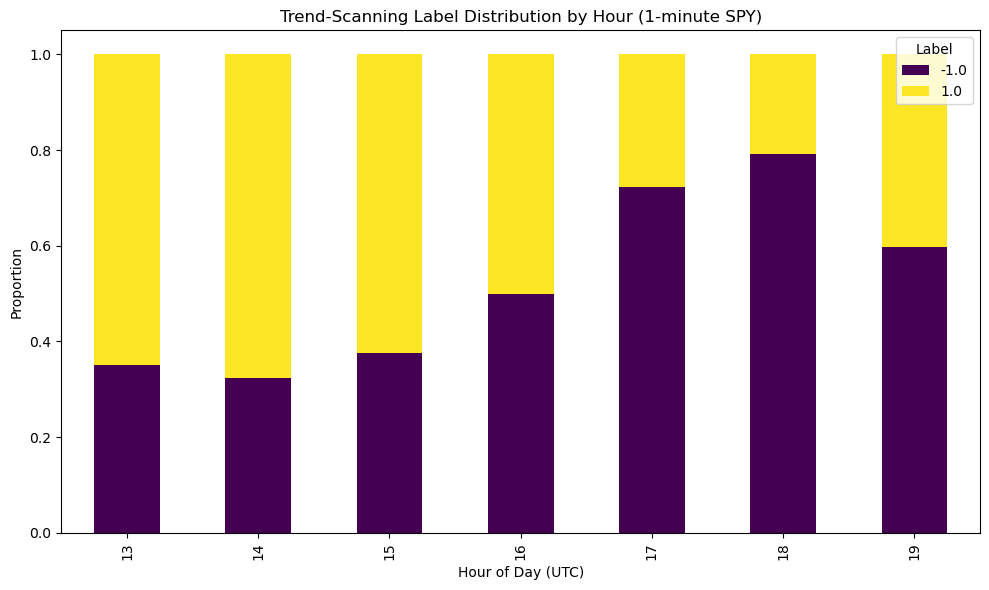

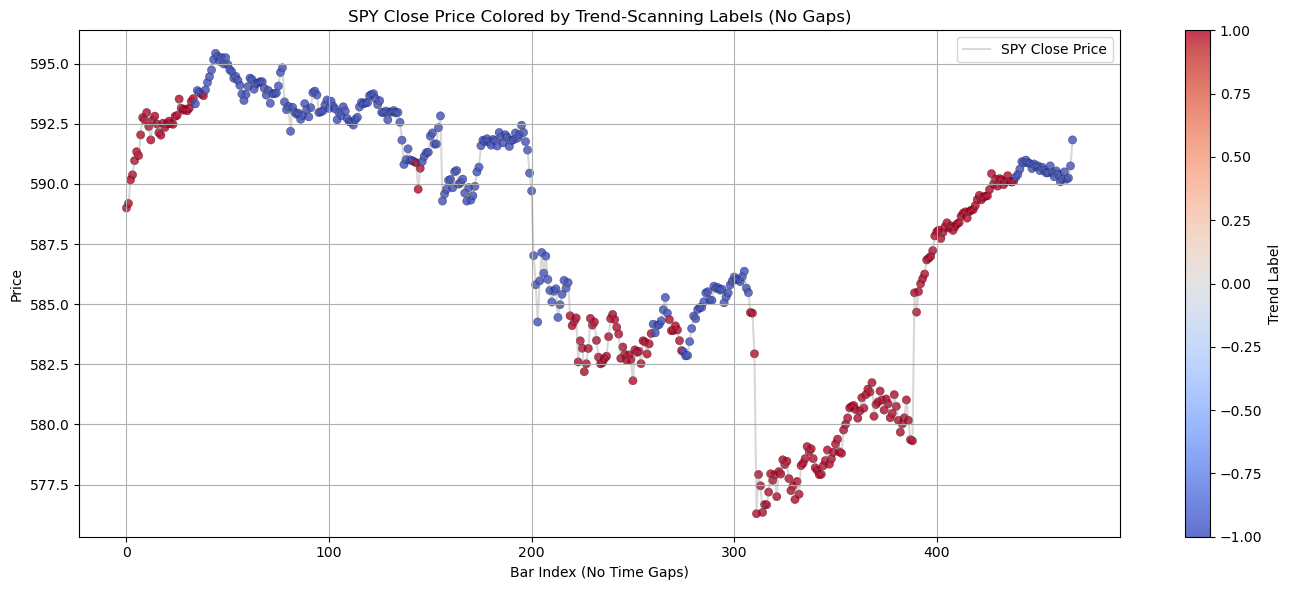

In [157]:
import statsmodels.api as sm

spy_raw = yf.download("SPY", interval="1m", period="7d", progress=False, auto_adjust=False)

close = spy_raw['Close'].copy()
close.index = pd.to_datetime(close.index)

span = [30, 390, 10]  # from 30 min to 390 min, in steps of 10

# Subsample timestamps (e.g., every 5 minutes)
molecule = close.iloc[::5].index

# Run trend labeling
trend_labels = getBinsFromTrend(molecule, close, span=span)

trend_labels['hour'] = trend_labels.index.hour

# Normalize value counts by hour
trend_label_dist = trend_labels.groupby('hour')['bin'].value_counts(normalize=True).unstack().fillna(0)
print(trend_label_dist)

ax = trend_label_dist.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Trend-Scanning Label Distribution by Hour (1-minute SPY)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Proportion")
plt.legend(title="Label", loc="upper right")
plt.tight_layout()
plt.show()

# Trend labels are in the form of a DataFrame with timestamps as index
# Align and clean trend labels
valid_idx = trend_labels.index.intersection(close.index)
plot_close = close.loc[valid_idx]
plot_labels = trend_labels.loc[valid_idx]['bin']

# Reset to integer index to remove time gaps
plot_close_reset = plot_close.reset_index(drop=True)
plot_labels_reset = plot_labels.reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
scatter = plt.scatter(
    plot_close_reset.index,
    plot_close_reset.values,
    c=plot_labels_reset.values,
    cmap='coolwarm',
    marker='o',
    edgecolors='k',
    linewidth=0.2,
    alpha=0.8
)

plt.plot(plot_close_reset.index, plot_close_reset.values, color='gray', alpha=0.3, label='SPY Close Price')
plt.title("SPY Close Price Colored by Trend-Scanning Labels (No Gaps)")
plt.xlabel("Bar Index (No Time Gaps)")
plt.ylabel("Price")
plt.grid(True)
plt.colorbar(scatter, label="Trend Label")
plt.legend()
plt.tight_layout()
plt.show()

### Exercise 5: Random Forest on Triple Barrier Method

Using the labels generated in **Exercise 3** (triple-barrier method):

a) Fit a **Random Forest classifier** on those labels.  
  Use as features:
- Mean return
- Volatility
- Skewness
- Kurtosis
- Various differences in moving averages

b) **Backtest** those predictions using the same trading rule used to generate the labels (enter trade based on prediction, exit after fixed horizon or when barrier hit).

c) Apply **meta-labeling** to the backtest results.

d) **Refit** the random forest on the meta-labels, adding the prediction from (a) as a new feature.

e) **Size bets** according to the predictions in (d), and **recompute** the backtest.


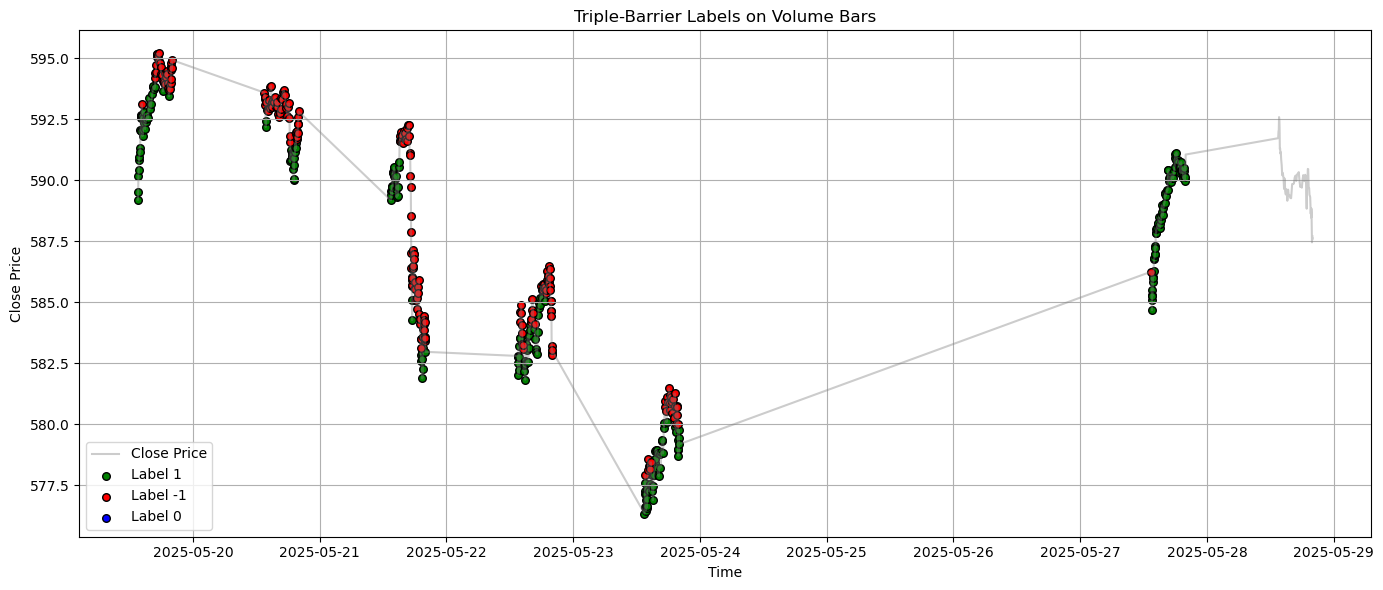

In [168]:
# Checking results from Ex 3:

plt.figure(figsize=(14, 6))
plt.plot(volume_bars['Close'], label='Close Price', color='gray', alpha=0.4)

colors = {1: 'green', -1: 'red', 0: 'blue'}
for label, color in colors.items():
    subset = volume_bars[volume_bars['label'] == label]
    plt.scatter(subset.index, subset['Close'], label=f'Label {label}', c=color, s=30, edgecolor='k')

plt.title("Triple-Barrier Labels on Volume Bars")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



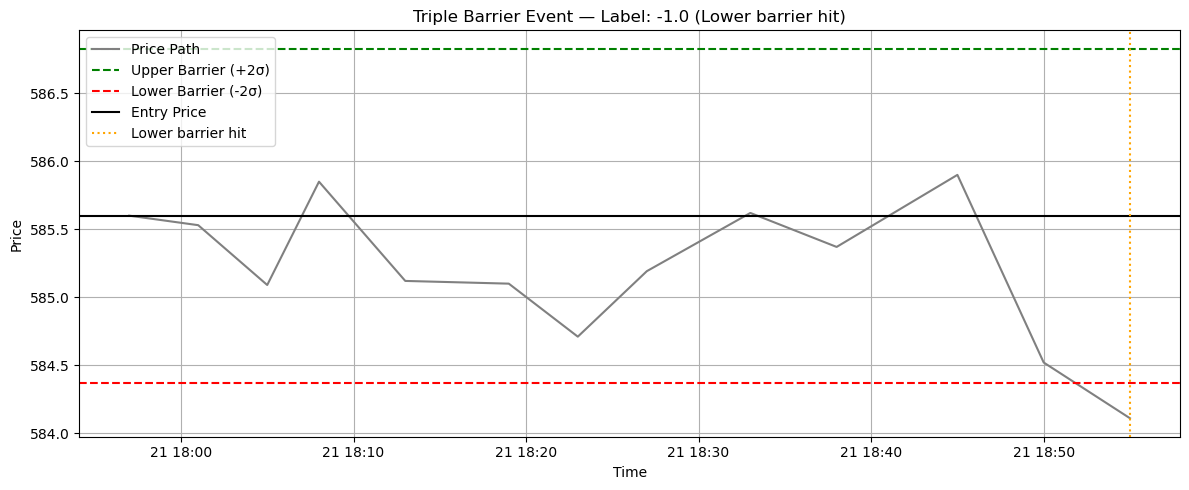

In [174]:
def plot_triple_barrier_event(volume_bars, entry_idx, horizon, barrier_width):
    """
    Visualize the triple-barrier logic around a specific bar, stopping at barrier breach.
    """
    if entry_idx + horizon >= len(volume_bars):
        print("Entry too close to end — skipping")
        return

    prices = volume_bars['Close'].iloc[entry_idx:entry_idx + horizon + 1]
    times = prices.index

    entry_price = prices.iloc[0]
    upper = entry_price * (1 + barrier_width)
    lower = entry_price * (1 - barrier_width)

    breached = None
    breach_time = None

    # Detect where the first barrier is hit
    for i, price in enumerate(prices[1:], start=1):
        if price >= upper:
            breached = 'upper'
            breach_time = times[i]
            prices = prices.iloc[:i+1]
            times = prices.index
            break
        elif price <= lower:
            breached = 'lower'
            breach_time = times[i]
            prices = prices.iloc[:i+1]
            times = prices.index
            break

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(times, prices, label="Price Path", color="gray")
    plt.axhline(upper, color='green', linestyle='--', label='Upper Barrier (+2σ)')
    plt.axhline(lower, color='red', linestyle='--', label='Lower Barrier (-2σ)')
    plt.axhline(entry_price, color='black', linestyle='-', label='Entry Price')

    if breach_time:
        plt.axvline(breach_time, color='orange', linestyle=':', label=f"{breached.capitalize()} barrier hit")

    label = volume_bars['label'].iloc[entry_idx]
    label_text = {1: "Upper barrier hit", -1: "Lower barrier hit", 0: "No barrier hit"}
    plt.title(f"Triple Barrier Event — Label: {label} ({label_text.get(label)})")

    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_triple_barrier_event(volume_bars, entry_idx=200, horizon=avg_holding_period, barrier_width=barrier_width)



In [175]:
# (a)

# --- Step 0: Prep volume_bars from Exercise 3 ---
# Assume: volume_bars already has 'label' and 'Close'

import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Step 1: Create ML features on volume bars ---

X = pd.DataFrame(index=volume_bars.index)

# Lookback window
w = 10  # bars

# Core return-based features
X['mean_return'] = volume_bars['Close'].pct_change().rolling(w).mean()
X['volatility'] = volume_bars['Close'].pct_change().rolling(w).std()
X['skew'] = volume_bars['Close'].pct_change().rolling(w).apply(stats.skew, raw=True)
X['kurtosis'] = volume_bars['Close'].pct_change().rolling(w).apply(stats.kurtosis, raw=True)

# Moving average features
X['ma_fast'] = volume_bars['Close'].rolling(window=5).mean()
X['ma_slow'] = volume_bars['Close'].rolling(window=20).mean()
X['ma_diff'] = X['ma_fast'] - X['ma_slow']

# Drop rows with NaNs
X = X.dropna()

# Labels (from Exercise 3)
y = volume_bars['label'].loc[X.index].dropna()
X = X.loc[y.index]  # Align features with cleaned labels

In [176]:
# --- Step 2: Train/Test Split and Fit Random Forest ---

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# --- Step 3: Evaluate Performance ---
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.15      0.56      0.23        27
         1.0       0.67      0.22      0.33       111

    accuracy                           0.28       138
   macro avg       0.41      0.39      0.28       138
weighted avg       0.57      0.28      0.31       138



In [183]:
# --- Step 4: Backtest Strategy from Predictions ---
# Use same rule as labeling: if pred==1, go long; if pred==-1, go short; else do nothing

avg_holding_period = 79  # from Exercise 3
results = pd.DataFrame(index=X_test.index.copy())
results['pred_label'] = y_pred
results['price'] = volume_bars['Close'].loc[results.index]

strategy_returns = []

for idx in results.index:
    pred = results.loc[idx, 'pred_label']
    entry_price = results.loc[idx, 'price']
    
    try:
        exit_idx = volume_bars.index.get_loc(idx) + avg_holding_period
        if exit_idx >= len(volume_bars):
            continue
        exit_price = volume_bars['Close'].iloc[exit_idx]
    except:
        continue

    if pred == 1.0:
        ret = (exit_price / entry_price) - 1
    elif pred == -1.0:
        ret = (entry_price / exit_price) - 1
    else:
        ret = 0.0

    strategy_returns.append({
        'timestamp': idx,
        'pred_label': pred,
        'return': ret
    })

bt = pd.DataFrame(strategy_returns).set_index('timestamp')
bt['cumulative_return'] = (1 + bt['return']).cumprod()

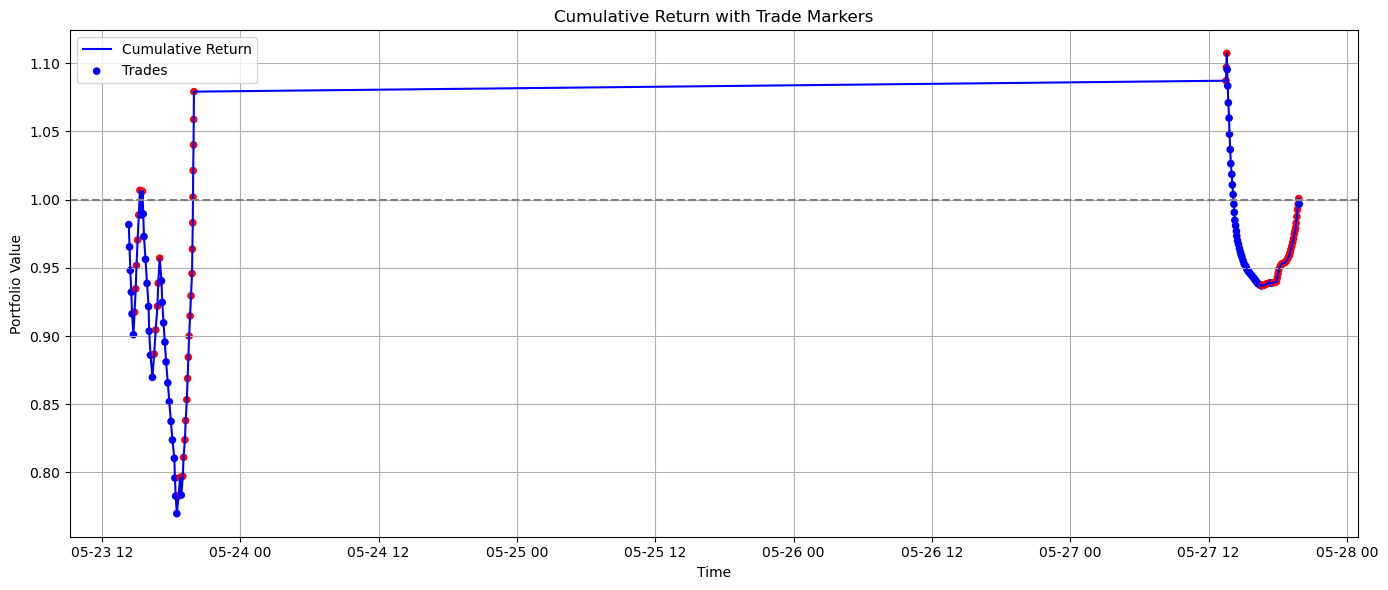

In [184]:
plt.figure(figsize=(14, 6))
plt.plot(bt['cumulative_return'], label='Cumulative Return', color='blue')
plt.scatter(bt.index, bt['cumulative_return'], c=(bt['return'] > 0), cmap='bwr', s=20, label='Trades')
plt.axhline(1.0, linestyle='--', color='gray')
plt.title("Cumulative Return with Trade Markers")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [186]:
meta_df = pd.DataFrame(index=X_test.index)
meta_df['true_label'] = y_test
meta_df['pred_label'] = y_pred
meta_df['correct'] = (meta_df['true_label'] == meta_df['pred_label']).astype(int)  # meta-label

X_meta = X_test.copy()
X_meta['pred_label'] = y_pred  # include original model's decision
y_meta = meta_df['correct']

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

meta_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
meta_clf.fit(X_meta, y_meta)

y_meta_pred = meta_clf.predict(X_meta)

print(classification_report(y_meta, y_meta_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        99
           1       0.95      1.00      0.97        39

    accuracy                           0.99       138
   macro avg       0.98      0.99      0.98       138
weighted avg       0.99      0.99      0.99       138



In [187]:
# Get meta-prediction: whether to trust each trade
meta_confidence = meta_clf.predict(X_meta)

filtered_results = pd.DataFrame(index=X_meta.index)
filtered_results['price'] = volume_bars['Close'].loc[X_meta.index]
filtered_results['pred_label'] = X_meta['pred_label']
filtered_results['trust'] = meta_confidence

# Apply the same backtest logic, but only take trades when trust == 1
filtered_trades = []

for idx in filtered_results.index:
    if filtered_results.loc[idx, 'trust'] != 1:
        continue

    pred = filtered_results.loc[idx, 'pred_label']
    entry_price = filtered_results.loc[idx, 'price']

    try:
        exit_idx = volume_bars.index.get_loc(idx) + avg_holding_period
        if exit_idx >= len(volume_bars):
            continue
        exit_price = volume_bars['Close'].iloc[exit_idx]
    except:
        continue

    if pred == 1.0:
        ret = (exit_price / entry_price) - 1
    elif pred == -1.0:
        ret = (entry_price / exit_price) - 1
    else:
        ret = 0.0

    filtered_trades.append({
        'timestamp': idx,
        'return': ret
    })

bt_meta = pd.DataFrame(filtered_trades).set_index('timestamp')
bt_meta['cumulative_return'] = (1 + bt_meta['return']).cumprod()


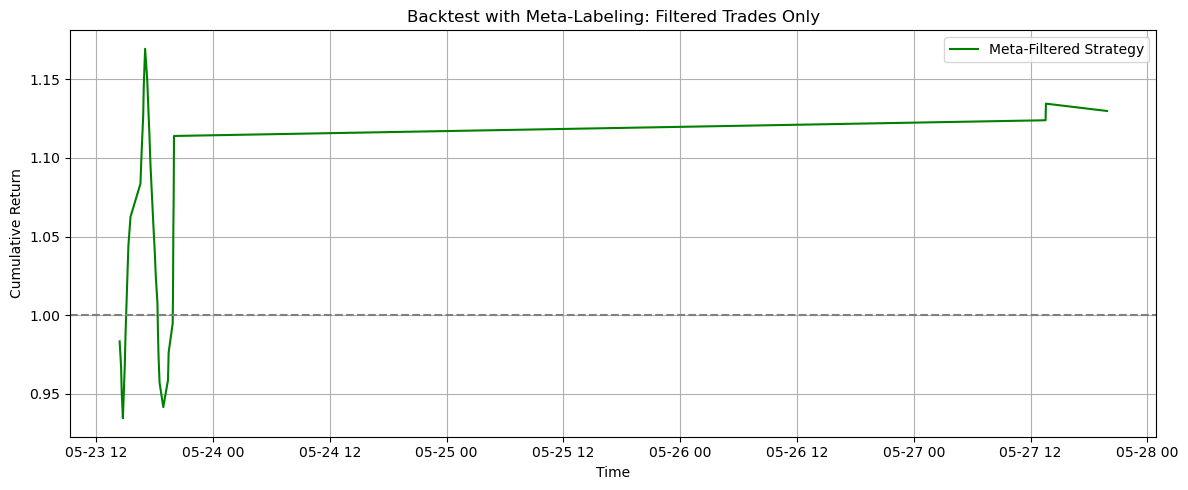

In [188]:
plt.figure(figsize=(12, 5))
plt.plot(bt_meta['cumulative_return'], label="Meta-Filtered Strategy", color='green')
plt.axhline(1.0, linestyle='--', color='gray')
plt.title("Backtest with Meta-Labeling: Filtered Trades Only")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [189]:
from scipy.stats import norm

# Probabilities that meta-model is confident
p_meta = meta_clf.predict_proba(X_meta)[:, 1]  # Confidence in '1' (correct)

# Compute z (Sharpe ratio estimate)
z = (p_meta - 0.5) / np.sqrt(p_meta * (1 - p_meta))

# Compute bet sizes: m ∈ [-1, 1]
m = 2 * norm.cdf(z) - 1

sized_results = pd.DataFrame(index=X_meta.index)
sized_results['price'] = volume_bars['Close'].loc[X_meta.index]
sized_results['pred_label'] = X_meta['pred_label']
sized_results['trust'] = meta_clf.predict(X_meta)
sized_results['bet_size'] = m  # continuous position size

# Backtest: apply bet size to each trade
sized_trades = []

for idx in sized_results.index:
    if sized_results.loc[idx, 'trust'] != 1:
        continue  # skip untrusted trades

    pred = sized_results.loc[idx, 'pred_label']
    entry_price = sized_results.loc[idx, 'price']
    size = sized_results.loc[idx, 'bet_size']

    try:
        exit_idx = volume_bars.index.get_loc(idx) + avg_holding_period
        if exit_idx >= len(volume_bars):
            continue
        exit_price = volume_bars['Close'].iloc[exit_idx]
    except:
        continue

    if pred == 1.0:
        ret = (exit_price / entry_price - 1) * size
    elif pred == -1.0:
        ret = (entry_price / exit_price - 1) * size
    else:
        ret = 0.0

    sized_trades.append({
        'timestamp': idx,
        'return': ret,
        'bet_size': size
    })

bt_sized = pd.DataFrame(sized_trades).set_index('timestamp')
bt_sized['cumulative_return'] = (1 + bt_sized['return']).cumprod()


/var/folders/qt/dwz57vhd5szdmf7nm9yzzb800000gn/T/ipykernel_91990/3431281473.py:7: RuntimeWarning: divide by zero encountered in divide
  z = (p_meta - 0.5) / np.sqrt(p_meta * (1 - p_meta))


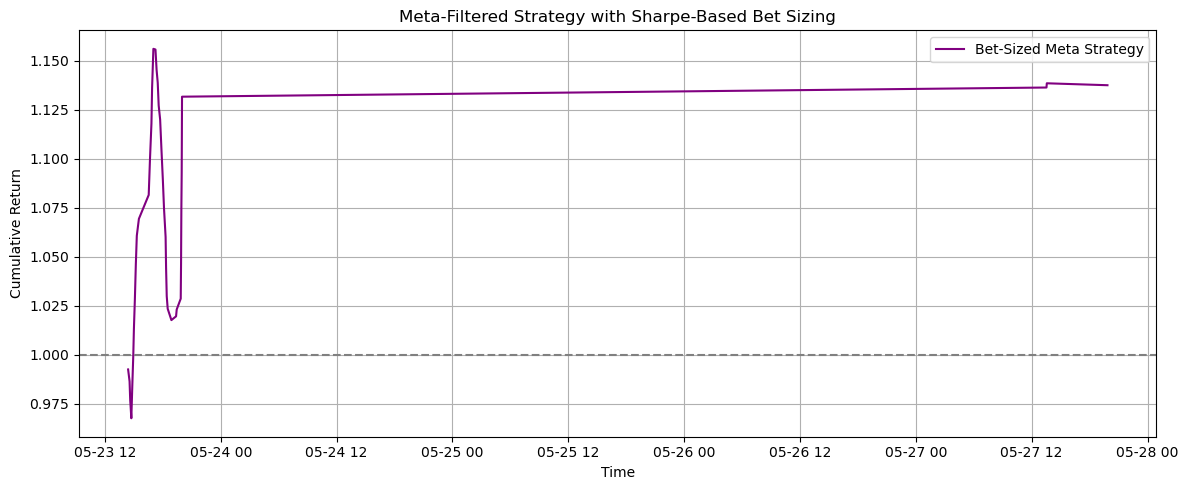

In [190]:
plt.figure(figsize=(12, 5))
plt.plot(bt_sized['cumulative_return'], label="Bet-Sized Meta Strategy", color='purple')
plt.axhline(1.0, linestyle='--', color='gray')
plt.title("Meta-Filtered Strategy with Sharpe-Based Bet Sizing")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
